In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
sns.set()

In [2]:
tesla = pd.read_csv('../dataset/TSLA.csv')
tesla['Date'] = pd.to_datetime(tesla['Date'])
tesla.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-03-23,62.250000,62.250000,60.090000,60.307999,60.307999,33274500
1,2018-03-26,61.467999,61.518002,58.271999,60.835999,60.835999,41876000
2,2018-03-27,60.799999,60.854000,55.436001,55.835999,55.835999,69360000
3,2018-03-28,52.916000,53.736000,50.419998,51.556000,51.556000,105007000
4,2018-03-29,51.298000,54.192001,49.641998,53.226002,53.226002,75853500


In [3]:
tesla.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
645,2020-10-14,449.779999,465.899994,447.350006,461.299988,461.299988,48045400
646,2020-10-15,450.309998,456.570007,442.500000,448.880005,448.880005,35672400
647,2020-10-16,454.440002,455.950012,438.850006,439.670013,439.670013,32775900
648,2020-10-19,446.239990,447.000000,428.869995,430.829987,430.829987,36287800
649,2020-10-20,431.750000,431.750000,419.049988,421.940002,421.940002,31656300


In [4]:
def df_shift(df,lag=0, start=1, skip=1, rejected_columns = []):
    df = df.copy()
    if not lag:
        return df
    cols ={}
    for i in range(start,lag+1,skip):
        for x in list(df.columns):
            if x not in rejected_columns:
                if not x in cols:
                    cols[x] = ['{}_{}'.format(x, i)]
                else:
                    cols[x].append('{}_{}'.format(x, i))
    for k,v in cols.items():
        columns = v
        dfn = pd.DataFrame(data=None, columns=columns, index=df.index)    
        i = (skip - 1)
        for c in columns:
            dfn[c] = df[k].shift(periods=i)
            i+=skip
        df = pd.concat([df, dfn], axis=1, join_axes=[df.index])
    return df

In [5]:
tesla = tesla[['Date','Close']]
tesla.head(1)

,Date,Close
0,2018-03-23,60.307999


In [6]:
df_crosscorrelated = df_shift(tesla, lag = 10, start = 1, skip = 2,rejected_columns=['Date'])
df_crosscorrelated['ma7'] = df_crosscorrelated['Close'].rolling(7).mean()
df_crosscorrelated['ma14'] = df_crosscorrelated['Close'].rolling(14).mean()
df_crosscorrelated['ma25'] = df_crosscorrelated['Close'].rolling(25).mean()
df_crosscorrelated.head(10)

/Users/bochmann/lib/anaconda3/envs/gcstf/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.


,Date,Close,Close_1,Close_3,Close_5,Close_7,Close_9,ma7,ma14,ma25
0,2018-03-23,60.307999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-03-26,60.835999,60.307999,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-03-27,55.835999,60.835999,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-03-28,51.556000,55.835999,60.307999,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-03-29,53.226002,51.556000,60.835999,NaN,NaN,NaN,NaN,NaN,NaN
5,2018-04-02,50.495998,53.226002,55.835999,60.307999,NaN,NaN,NaN,NaN,NaN
6,2018-04-03,53.506001,50.495998,51.556000,60.835999,NaN,NaN,55.109143,NaN,NaN
7,2018-04-04,57.388000,53.506001,53.226002,55.835999,60.307999,NaN,54.692000,NaN,NaN
8,2018-04-05,61.144001,57.388000,50.495998,51.556000,60.835999,NaN,54.736000,NaN,NaN
9,2018-04-06,59.860001,61.144001,53.506001,53.226002,55.835999,60.307999,55.310858,NaN,NaN


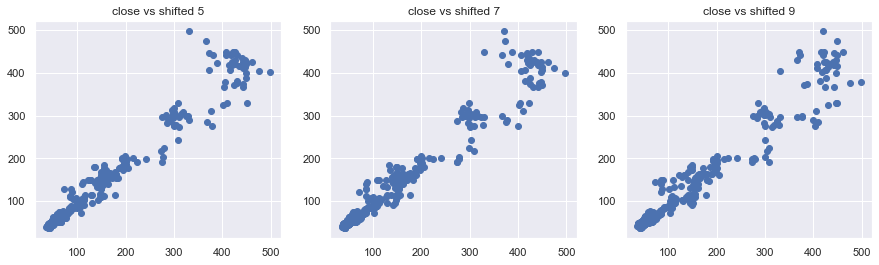

In [7]:
plt.figure(figsize=(15, 4))
plt.subplot(1,3,1)
plt.scatter(df_crosscorrelated['Close'],df_crosscorrelated['Close_5'])
plt.title('close vs shifted 5')
plt.subplot(1,3,2)
plt.scatter(df_crosscorrelated['Close'],df_crosscorrelated['Close_7'])
plt.title('close vs shifted 7')
plt.subplot(1,3,3)
plt.scatter(df_crosscorrelated['Close'],df_crosscorrelated['Close_9'])
plt.title('close vs shifted 9')
plt.show()

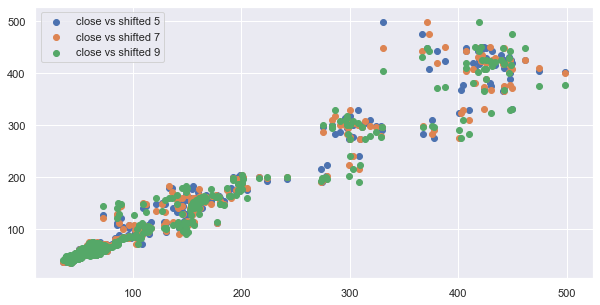

In [8]:
plt.figure(figsize=(10,5))
plt.scatter(df_crosscorrelated['Close'],df_crosscorrelated['Close_5'],label='close vs shifted 5')
plt.scatter(df_crosscorrelated['Close'],df_crosscorrelated['Close_7'],label='close vs shifted 7')
plt.scatter(df_crosscorrelated['Close'],df_crosscorrelated['Close_9'],label='close vs shifted 9')
plt.legend()
plt.show()

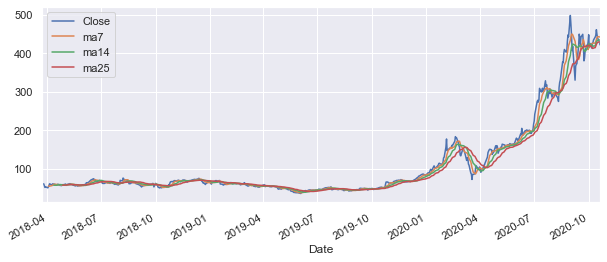

In [9]:
fig, ax = plt.subplots(figsize=(10,4))
df_crosscorrelated.plot(x='Date',y=['Close','ma7','ma14','ma25'],ax=ax)
plt.show()

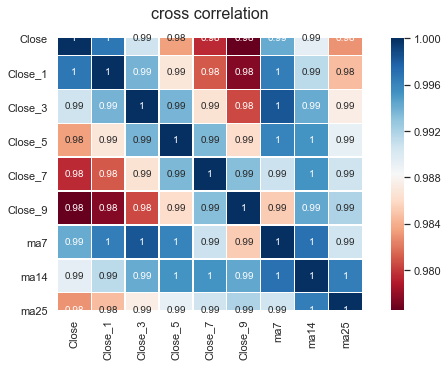

In [10]:
colormap = plt.cm.RdBu
plt.figure(figsize=(10, 5))
ax=plt.subplot(111)
plt.title('cross correlation', y=1.05, size=16)
selected_column = ['Close','Close_1','Close_3','Close_5','Close_7','Close_9','ma7','ma14','ma25']

sns.heatmap(df_crosscorrelated[selected_column].corr(), ax=ax, linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)
plt.show()

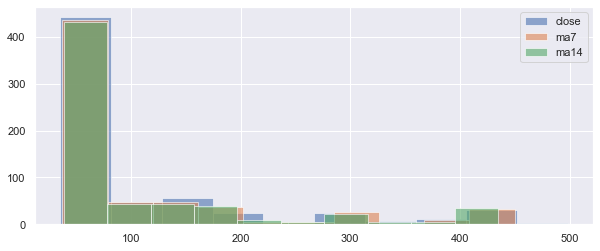

In [11]:
fig, ax = plt.subplots(figsize=(10,4))
df_crosscorrelated['Close'].hist(alpha=0.6,label='close',ax=ax)
df_crosscorrelated['ma7'].hist(alpha=0.6,label='ma7',ax=ax)
df_crosscorrelated['ma14'].hist(alpha=0.6,label='ma14',ax=ax)
plt.legend()
plt.show()

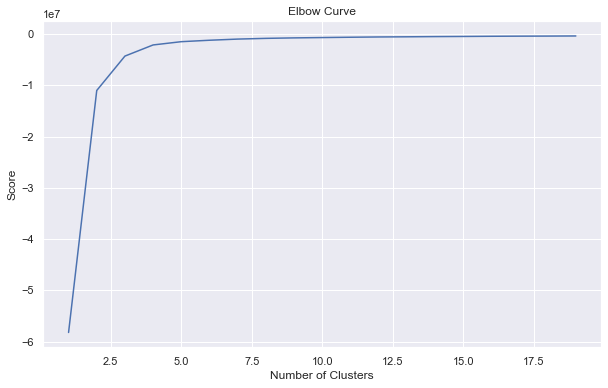

In [12]:
from sklearn.cluster import KMeans

n_cluster = range(1, 20)
data = df_crosscorrelated.iloc[:,1:].dropna().values
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(n_cluster, scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

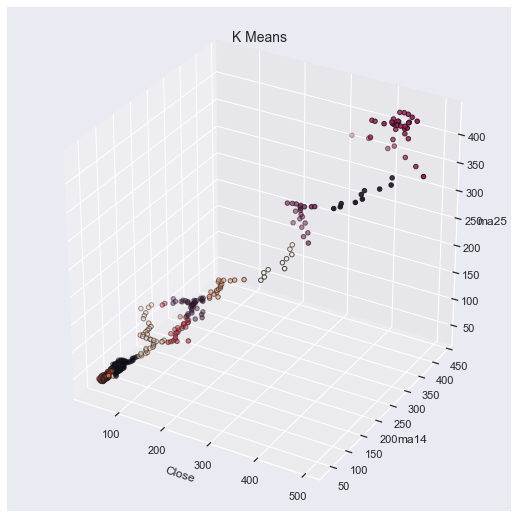

In [13]:
from mpl_toolkits.mplot3d import Axes3D

X = df_crosscorrelated[['Close','ma14','ma25']].dropna()
X = X.reset_index(drop=True)
km = KMeans(n_clusters=10)
km.fit(X)
km.predict(X)
labels = km.labels_

fig = plt.figure(1, figsize=(7,7))
ax = Axes3D(fig)
ax.scatter(X.iloc[:,0], X.iloc[:,1], X.iloc[:,2],
          c=labels.astype(np.float), edgecolor="k")
ax.set_xlabel("Close")
ax.set_ylabel("ma14")
ax.set_zlabel("ma25")
plt.title("K Means", fontsize=14)
plt.show()

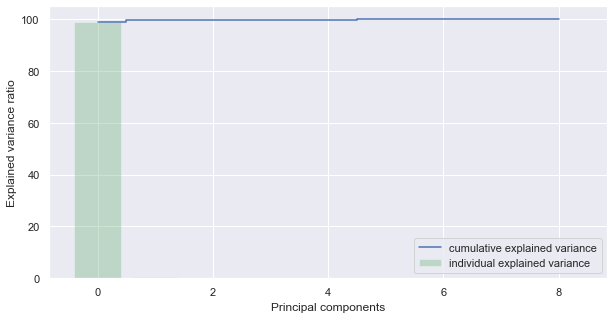

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X = df_crosscorrelated.iloc[:,1:].dropna().values
X_std = StandardScaler().fit_transform(X)

mean_vec = np.mean(X_std, axis=0)
cov_mat = np.cov(X_std.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

eig_pairs = [(np.abs(eig_vals[i]),eig_vecs[:,i]) for i in range(len(eig_vals))]

eig_pairs.sort(key = lambda x: x[0], reverse= True)

tot = sum(eig_vals)
var_exp = [(i/tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

plt.figure(figsize=(10, 5))
plt.bar(range(len(var_exp)), var_exp, alpha=0.3, align='center', label='individual explained variance', color = 'g')
plt.step(range(len(cum_var_exp)), cum_var_exp, where='mid',label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.show();

In [15]:
X = df_crosscorrelated.iloc[:,1:].dropna().values
X_std = StandardScaler().fit_transform(X)
data = pd.DataFrame(X_std)
pca = PCA(n_components=2)
data = pca.fit_transform(data)
scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)

In [16]:
df = df_crosscorrelated.dropna()
kmeans = KMeans(n_clusters=10).fit(np_scaled)
df['cluster'] = kmeans.predict(np_scaled)
df = df.reset_index()
df['principal_feature1'] = np_scaled[:,0]
df['principal_feature2'] = np_scaled[:,1]
df['cluster'].value_counts()

/Users/bochmann/lib/anaconda3/envs/gcstf/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0    288
8    169
6     54
2     22
5     21
9     19
7     19
3     19
1     11
4      4
Name: cluster, dtype: int64

In [17]:
def getDistanceByPoint(data, model):
    distance = pd.Series()
    for i in range(0,len(data)):
        Xa = data[i]
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.set_value(i, np.linalg.norm(Xa-Xb))
    return distance

outliers_fraction = 0.1
distance = getDistanceByPoint(np_scaled, kmeans)
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()
df['anomaly1'] = (distance >= threshold).astype(int)

/Users/bochmann/lib/anaconda3/envs/gcstf/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


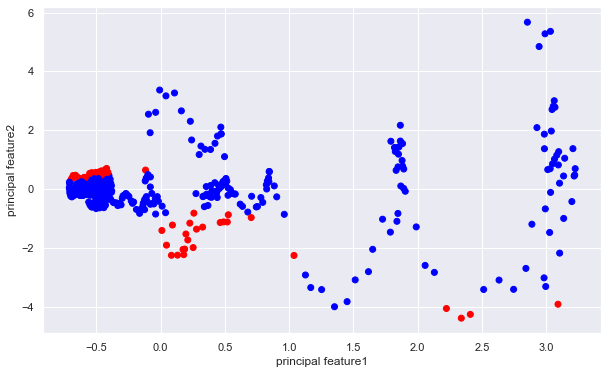

In [18]:
fig, ax = plt.subplots(figsize=(10,6))
colors = {0:'blue', 1:'red'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["anomaly1"].apply(lambda x: colors[x]))
plt.xlabel('principal feature1')
plt.ylabel('principal feature2')
plt.show()

In [19]:
df.anomaly1.value_counts()

0    564
1     62
Name: anomaly1, dtype: int64

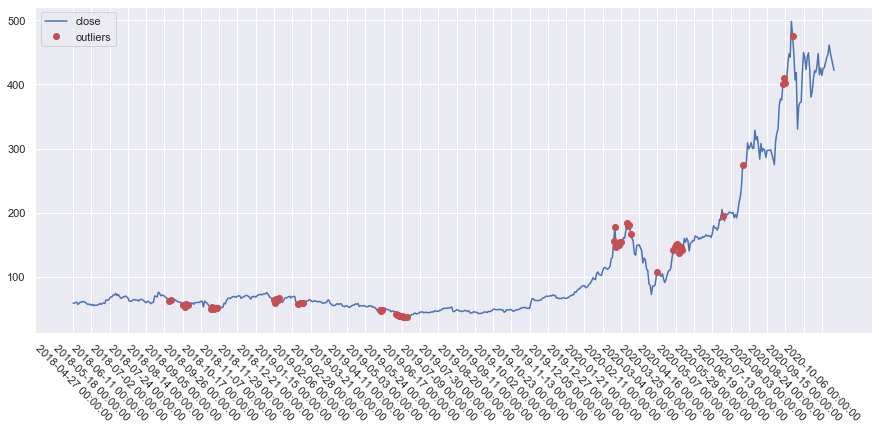

In [20]:
plt.figure(figsize=(15, 6))
plt.plot(df['Close'], label='close',c='b')
plt.plot(df['Close'], 'o', label='outliers',markevery=df.loc[df['anomaly1'] == 1].index.tolist(),c='r')
plt.xticks(np.arange(df.shape[0])[::15],df['Date'][::15],rotation='-45')
plt.legend()
plt.show()

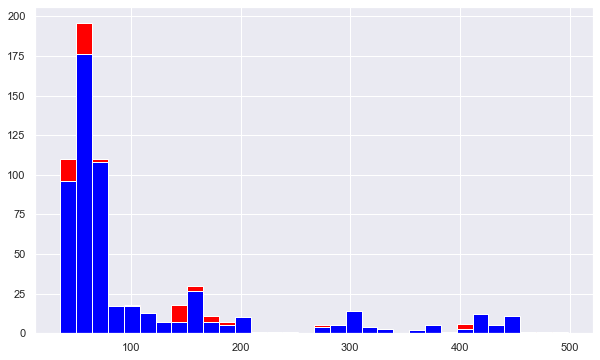

In [21]:
a = df.loc[df['anomaly1'] == 0, 'Close']
b = df.loc[df['anomaly1'] == 1, 'Close']

fig, axs = plt.subplots(figsize=(10,6))
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'])
plt.show()

In [22]:
ori_len = df_crosscorrelated.shape[0] - X.shape[0]
ori_len

24

In [23]:
#np.where(outliers==-1)[0] + ori_len

I will use IsolationForest from sklearn library. When defining the algorithm there is an important parameter called contamination. It is the percentage of observations that the algorithm will expect as outliers. We fit the X (2 features HP and Speed) to the algorithm and use fit_predict to use it also on X. This produces plain outliers (-1 is outlier, 1 is inlier). We can also use the function decision_function to get the scores Isolation Forest gave to each sample.

/Users/bochmann/lib/anaconda3/envs/gcstf/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/bochmann/lib/anaconda3/envs/gcstf/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


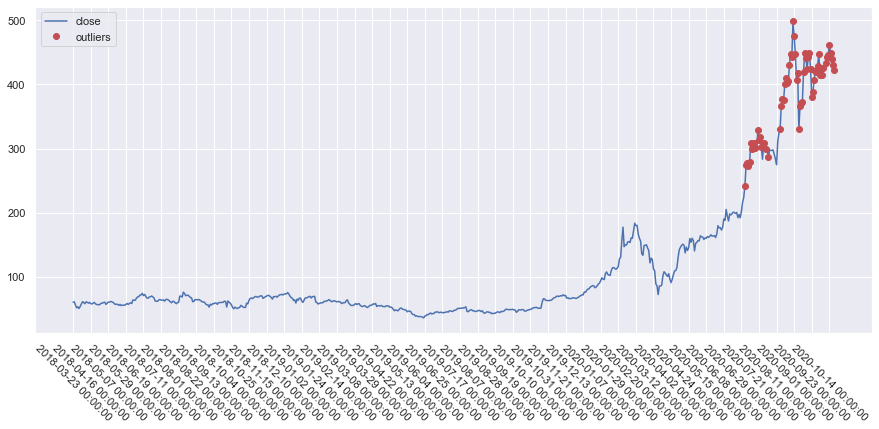

In [24]:
from sklearn.ensemble import IsolationForest

X = df_crosscorrelated.iloc[:,1:].dropna().values
np_scaled = StandardScaler().fit_transform(X)

model = IsolationForest(contamination=outliers_fraction)
model.fit(np_scaled)
outliers = model.predict(np_scaled)

plt.figure(figsize=(15, 6))
plt.plot(df_crosscorrelated['Close'], label='close',c='b')
plt.plot(df_crosscorrelated['Close'], 'o', label='outliers',
         markevery=(np.where(outliers==-1)[0] + ori_len).tolist(),c='r')
plt.xticks(np.arange(df_crosscorrelated.shape[0])[::15],df_crosscorrelated['Date'][::15],rotation='-45')
plt.legend()
plt.show()

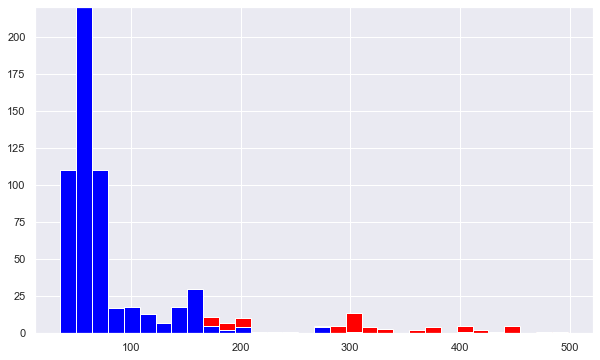

In [25]:
close = df_crosscorrelated['Close'].values
a = close[np.where(outliers==1)[0]]
b = close[np.where(outliers==-1)[0]]

fig, axs = plt.subplots(figsize=(10,6))
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'])
plt.show()

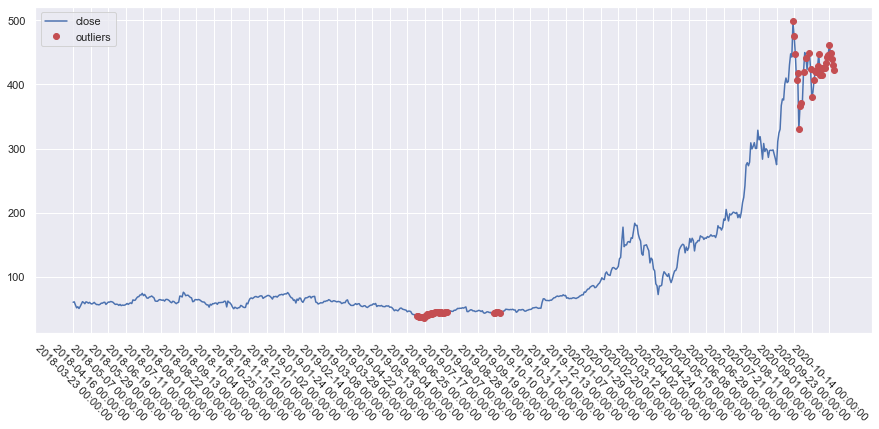

In [26]:
from sklearn.svm import OneClassSVM

X = df_crosscorrelated.iloc[:,1:].dropna().values
np_scaled = StandardScaler().fit_transform(X)
model = OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma=0.01)
model.fit(np_scaled)
outliers = model.predict(np_scaled)

plt.figure(figsize=(15, 6))
plt.plot(df_crosscorrelated['Close'], label='close',c='b')
plt.plot(df_crosscorrelated['Close'], 'o', label='outliers',
         markevery=(np.where(outliers==-1)[0] + ori_len).tolist(),c='r')
plt.xticks(np.arange(df_crosscorrelated.shape[0])[::15],df_crosscorrelated['Date'][::15],rotation='-45')
plt.legend()
plt.show()

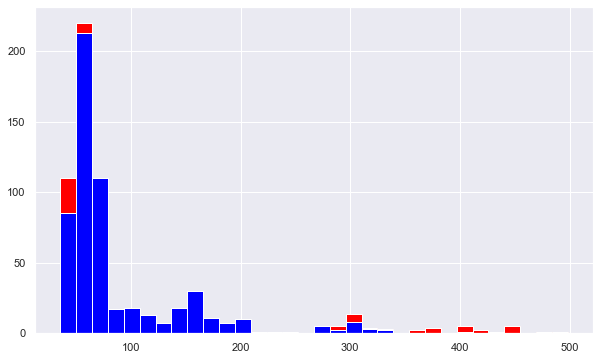

In [27]:
close = df_crosscorrelated['Close'].values
a = close[np.where(outliers==1)[0]]
b = close[np.where(outliers==-1)[0]]

fig, axs = plt.subplots(figsize=(10,6))
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'])
plt.show()

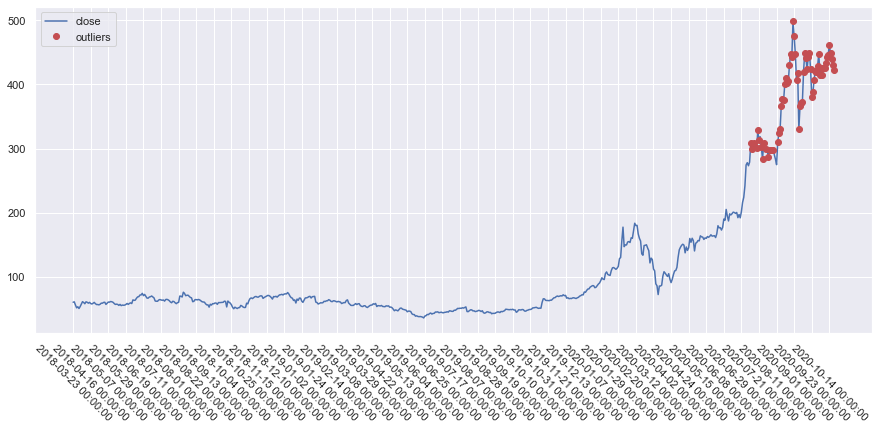

In [28]:
from sklearn.covariance import EllipticEnvelope

envelope = EllipticEnvelope(contamination = outliers_fraction)
X = df_crosscorrelated.iloc[:,1:].dropna().values
np_scaled = StandardScaler().fit_transform(X)
envelope.fit(np_scaled)
outliers = envelope.predict(np_scaled)

plt.figure(figsize=(15, 6))
plt.plot(df_crosscorrelated['Close'], label='close',c='b')
plt.plot(df_crosscorrelated['Close'], 'o', label='outliers',
         markevery=(np.where(outliers==-1)[0] + ori_len).tolist(),c='r')
plt.xticks(np.arange(df_crosscorrelated.shape[0])[::15],df_crosscorrelated['Date'][::15],rotation='-45')
plt.legend()
plt.show()

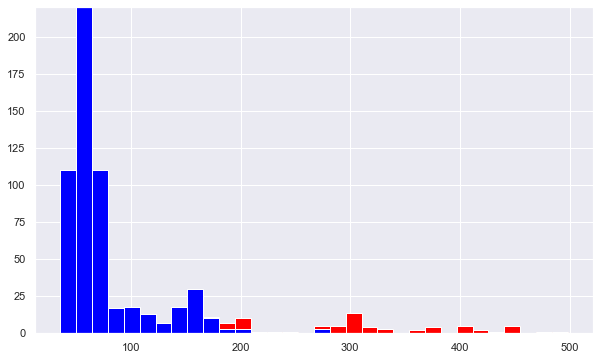

In [29]:
close = df_crosscorrelated['Close'].values
a = close[np.where(outliers==1)[0]]
b = close[np.where(outliers==-1)[0]]

fig, axs = plt.subplots(figsize=(10,6))
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'])
plt.show()